# Calculando o VaR pela covariância

In [1]:
# Carregando as bibliotecas

import pandas as pd
import numpy as np

import yfinance
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import kaleido

import plotly.figure_factory as ff
from scipy.stats import shapiro
from scipy.stats import norm

import warnings

warnings.filterwarnings("ignore")

import os
cwd = os.getcwd()

In [2]:
tickers = ["PETR4.SA", "VALE", "ITUB4.SA"
           , "CMIG4.SA", "USIM5.SA", "CSNA3.SA"]

start = "2020-01-02"
end = "2022-12-31"

df0 = yfinance.download(tickers, start, end)["Adj Close"]
df0 = df0.dropna(axis = 0) 

retornos = df0.pct_change()

[*********************100%***********************]  6 of 6 completed


In [3]:
# Vamos selecionar uma carteira com pesos aleatórios para cada ativo

pesos = np.random.dirichlet(np.ones(6), size = 1)
pesos

array([[0.02378171, 0.1537634 , 0.22180123, 0.15811369, 0.01345234,
        0.42908763]])

In [4]:
retornos_portfolio = retornos.mul(pesos, axis = 1)
retornos_portfolio

,CMIG4.SA,CSNA3.SA,ITUB4.SA,PETR4.SA,USIM5.SA,VALE
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.000257,-0.001151,-0.002333,-0.001288,-0.000139,-0.005104
2020-01-06,0.000329,-0.003797,-0.003301,0.001869,-0.000252,-0.004843
2020-01-07,0.000871,0.000000,-0.005146,-0.000616,0.000129,0.002939
2020-01-08,0.000659,-0.000216,-0.003614,-0.000979,-0.000170,-0.000324
...,...,...,...,...,...,...
2022-12-19,-0.000500,-0.003095,0.006650,0.002366,-0.000824,0.000801
2022-12-20,0.000754,0.005979,0.002364,0.004875,0.000292,0.009061
2022-12-21,-0.000043,0.000869,0.000900,0.003427,-0.000038,0.003915


In [5]:
retornos["Portfolio"] = retornos_portfolio.sum(axis = 1)
retornos["Portfolio"] = retornos["Portfolio"]*100
retornos.dropna(inplace = True)
retornos

,CMIG4.SA,CSNA3.SA,ITUB4.SA,PETR4.SA,USIM5.SA,VALE,Portfolio
Date,,,,,,,
2020-01-03,-0.010807,-0.007488,-0.010518,-0.008143,-0.010309,-0.011896,-1.027187
2020-01-06,0.013838,-0.024691,-0.014882,0.011822,-0.018750,-0.011287,-0.999430
2020-01-07,0.036638,0.000000,-0.023199,-0.003895,0.009554,0.006849,-0.182269
2020-01-08,0.027720,-0.001406,-0.016294,-0.006191,-0.012618,-0.000756,-0.464405
2020-01-09,-0.008092,-0.010563,-0.019932,-0.003279,-0.006390,-0.017398,-1.430730
...,...,...,...,...,...,...,...
2022-12-19,-0.021005,-0.020129,0.029983,0.014966,-0.061224,0.001867,0.539936
2022-12-20,0.031716,0.038885,0.010660,0.030831,0.021739,0.021118,2.332650
2022-12-21,-0.001808,0.005650,0.004057,0.021673,-0.002837,0.009124,0.902920


In [6]:
cov_retornos = retornos.iloc[:, 0:6].cov()
media_retornos = retornos.iloc[:, 0:6].mean()
cov_retornos

,CMIG4.SA,CSNA3.SA,ITUB4.SA,PETR4.SA,USIM5.SA,VALE
CMIG4.SA,0.000716,0.000471,0.000363,0.000468,0.000459,0.000393
CSNA3.SA,0.000471,0.001585,0.000428,0.000665,0.001165,0.000977
ITUB4.SA,0.000363,0.000428,0.000566,0.000452,0.000400,0.000373
PETR4.SA,0.000468,0.000665,0.000452,0.001112,0.000617,0.000632
USIM5.SA,0.000459,0.001165,0.000400,0.000617,0.001388,0.000828
VALE,0.000393,0.000977,0.000373,0.000632,0.000828,0.001036


In [7]:
media_retornos

CMIG4.SA    0.001027
CSNA3.SA    0.000946
ITUB4.SA   -0.000145
PETR4.SA    0.001330
USIM5.SA    0.000421
VALE        0.001172
dtype: float64

In [8]:
# Calculando a média dos retornos ponderados e a média da carteira

media_portfolio = media_retornos@pesos.T
sd_portfolio = np.sqrt(pesos@cov_retornos@pesos.T)

In [9]:
ci5 = 0.05
ci1 = 0.01
var5_cov = np.round(norm.ppf(ci5, media_portfolio, sd_portfolio), 4)*100
var1_cov = np.round(norm.ppf(ci1, media_portfolio, sd_portfolio), 4)*100

n = 5 #número de dias
var5_cov_n = np.round(var5_cov*np.sqrt(n), 2)
var1_cov_n = np.round(var1_cov*np.sqrt(n), 2)


print("Pelo método da covariância")
print("--------------------------")
print("Existe 5% de chances do portfolio perder mais de " + str(var5_cov[0][0]) + "% em 1 dia")
print("Existe 1% de chances do portfolio perder mais de " + str(var1_cov[0][0]) + "% em 1 dia")
print("")
print("Existe 5% de chances do portfolio perder mais de " + str(var5_cov_n[0][0]) + "% em " + str(n) + " dias")
print("Existe 1% de chances do portfolio perder mais de " + str(var1_cov_n[0][0]) + "% em " + str(n) + " dias")

Pelo método da covariância
--------------------------
Existe 5% de chances do portfolio perder mais de -4.2700000000000005% em 1 dia
Existe 1% de chances do portfolio perder mais de -6.08% em 1 dia

Existe 5% de chances do portfolio perder mais de -9.55% em 5 dias
Existe 1% de chances do portfolio perder mais de -13.6% em 5 dias


In [ ]:
#Lembrando o método do percentil

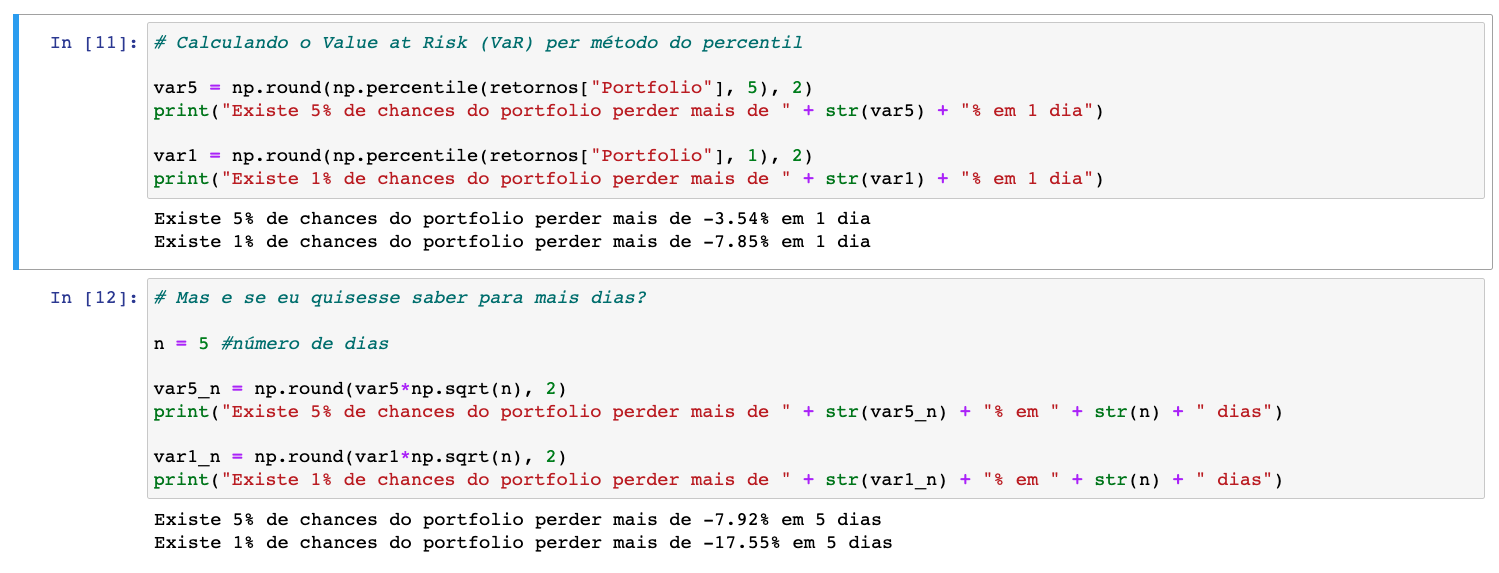

In [ ]:
# A diferença é pequena? Não quando você está falando de milhões...

# O problema do VaR

In [13]:
# Primeiro de tudo: os retornos deveriam seguir uma distribuição normal....

stat, p = shapiro(retornos.iloc[:,6])

# p <= alpha: reject H0, not normal.
# p > alpha: fail to reject H0, normal.

#https://plotly.com/python/v3/normality-test/
    
alpha = 0.05
if p > alpha:
    msg = 'Amostra Gaussiana (não rejeita H0)'
else:
    msg = 'Amostra não Gaussiana (rejeita H0)'

result_mat = [
    ["Tamanho da amostra", "Teste Estatístico", 'p-value', 'Comentário'],
    [len(retornos.iloc[:,2]), stat, p, msg]
]
swt_table = ff.create_table(result_mat)
swt_table['data'][0].colorscale=[[0, 'blue'],[1, '#ffffff']]
swt_table['layout']['height'] = 100
swt_table['layout']['width'] = 950
swt_table['layout']['margin']['t'] = 10
swt_table['layout']['margin']['b'] = 10
swt_table